Import libraries

In [ ]:
# duplicate libiomp5.dylib error fix
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

In [ ]:
# imports
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn import init
from torch.nn import functional as F
import math

import time
import neurogym as ngym

import logging
from sklearn.decomposition import PCA

In [46]:
import matplotlib.pyplot as plt # type: ignore
import scienceplots # type: ignore
plt.style.use('science')
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
# parameters for the science style -- too many 
plt.style.use(['science','no-latex'])
plt.rcParams.update({
    "font.size": 16,
    "axes.labelsize": 16,
    "legend.fontsize": 16,
    "xtick.labelsize": 16,
    "ytick.labelsize": 16,
    "axes.linewidth": 1,
    "axes.edgecolor": "black",
    "legend.fancybox": True,
    "legend.frameon": True,
    "legend.edgecolor": "black",
    "axes.facecolor": "white",
    "axes.grid": True,
    "grid.color": "#b7b7b7",
    "grid.linestyle": "-",
    "grid.linewidth": 0.5,
})

## NeuroGym Task 1

In [47]:
task_name = 'PerceptualDecisionMaking-v0'
kwargs = {'dt': 20, 'timing': {'stimulus': 1000}}

In [48]:
# Make supervised dataset
seq_len = 100
batch_size = 16
#Create the dataset (Hover over ngym.Dataset to see input arguments)
dataset = ngym.Dataset(task_name, env_kwargs=kwargs, seq_len=seq_len, batch_size=batch_size)
env = dataset.env

# Generate one batch of data when called
inputs, target = dataset()
inputs = torch.from_numpy(inputs).type(torch.float)

input_size = env.observation_space.shape[0]
output_size = env.action_space.n

print('Input has shape (SeqLen, Batch, Dim) =', inputs.shape)
print('Target has shape (SeqLen, Batch) =', target.shape)

Input has shape (SeqLen, Batch, Dim) = torch.Size([100, 16, 3])
Target has shape (SeqLen, Batch) = (100, 16)


### Define Training Model

In [70]:
def train_model(net, dataset, criterion, model = None, return_train = False, steps_num = 2000, sub_steps = 100):
    """Simple helper function to train the model.

    Args:
        net: a pytorch nn.Module module
        dataset: a dataset object that when called produce a (input, target output) pair
        criterion: a pytorch loss function
        model: a model object that is used in the loss function

    Returns:
        net: network object after training
    """
    # Use Adam optimizer
    optimizer = optim.Adam(net.parameters(), lr=0.01)
    
    # Initialize the lists to store the loss and steps
    steps = []
    losses = []

    running_loss = 0
    running_acc = 0
    start_time = time.time()
    # Loop over training batches
    print('Training network...')
    for i in range(steps_num):
        # Generate input and target, convert to pytorch tensor
        inputs, labels = dataset()
        inputs = torch.from_numpy(inputs).type(torch.float)
        labels = torch.from_numpy(labels.flatten()).type(torch.long)

        # boiler plate pytorch training:
        optimizer.zero_grad()   # zero the gradient buffers
        output, _ = net(inputs)
        # Reshape to (SeqLen x Batch, OutputSize)
        output = output.view(-1, output_size)
        if model == None:
            loss = criterion(output, labels)
        else:
            loss = criterion(output, labels, model)
        loss.backward()
        optimizer.step()    # Does the update

        # Compute the running loss every 100 steps
        running_loss += loss.item()
        if i % sub_steps == sub_steps-1:
            running_loss /= sub_steps
            print('Step {}, Loss {:0.4f}, Time {:0.1f}s'.format(
                i+1, running_loss, time.time() - start_time))
            

            # Append the loss and step
            steps.append(i+1)
            losses.append(running_loss)

            running_loss = 0

    # Return the trained network
    if return_train:
        return net, steps, losses
    else:
        return net

### Brian like penalties for cost function

In [65]:
# define penalties
def sparsity_penalty(model, beta_sparsity=0.5):
    """Compute sparsity penalty based on the model's weights."""
    return beta_sparsity * torch.sum(torch.abs(model.fc.weight))

def firing_rate_penalty(output, beta_firing_rate=0.5):
    """Compute penalty for high firing rates based on the model's output."""
    return beta_firing_rate * torch.sum(torch.square(output))


# define loss function
def loss_brain_penalties(output, target, model, 
                                beta_sparsity=0.05, beta_firing_rate=0.5):
    """
    Compute the total loss with added penalties for sparsity, firing rate, and long-distance connections.
    """
    # Base task-specific loss - same as before
    loss = nn.CrossEntropyLoss()(output, target)

    # Add penalties
    total_loss = loss
    total_loss += sparsity_penalty(model, beta_sparsity)
    total_loss += firing_rate_penalty(output, beta_firing_rate)
    
    return total_loss

## Model 1: Leaky RNN (from notes)

In [66]:
class LeakyRNN(nn.Module):
    """Leaky RNN.

    Parameters:
        input_size: Number of input neurons
        hidden_size: Number of hidden neurons
        dt: discretization time step in ms.
            If None, dt equals time constant tau

    Inputs:
        input: tensor of shape (seq_len, batch, input_size)
        hidden: tensor of shape (batch, hidden_size), initial hidden activity
            if None, hidden is initialized through self.init_hidden()

    Outputs:
        output: tensor of shape (seq_len, batch, hidden_size)
        hidden: tensor of shape (batch, hidden_size), final hidden activity
    """

    def __init__(self, input_size, hidden_size, dt=None, **kwargs):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.tau = 100
        if dt is None:
            alpha = 1
        else:
            alpha = dt / self.tau
        self.alpha = alpha

        self.input2h = nn.Linear(input_size, hidden_size)
        self.h2h = nn.Linear(hidden_size, hidden_size)

    def init_hidden(self, input_shape):
        batch_size = input_shape[1]
        return torch.zeros(batch_size, self.hidden_size)

    def recurrence(self, input, hidden):
        """Run network for one time step.

        Inputs:
            input: tensor of shape (batch, input_size)
            hidden: tensor of shape (batch, hidden_size)

        Outputs:
            h_new: tensor of shape (batch, hidden_size),
                network activity at the next time step
        """
        h_new = torch.relu(self.input2h(input) + self.h2h(hidden))

        #implement how much the previous hidden layer activity should be maintained in the new activity
        h_new = hidden * (1 - self.alpha) + h_new * self.alpha
        return h_new

    def forward(self, input, hidden=None):
        """Propogate input through the network."""

        # If hidden activity is not provided, initialize it
        if hidden is None:
            hidden = self.init_hidden(input.shape).to(input.device)

        # Loop through time
        output = []
        steps = range(input.size(0))
        for i in steps:
            hidden = self.recurrence(input[i], hidden)
            output.append(hidden)

        # Stack together output from all time steps
        output = torch.stack(output, dim=0)  # (seq_len, batch, hidden_size)
        return output, hidden


class RNNNet(nn.Module):
    """Recurrent network model.

    Parameters:
        input_size: int, input size
        hidden_size: int, hidden size
        output_size: int, output size

    Inputs:
        x: tensor of shape (Seq Len, Batch, Input size)

    Outputs:
        out: tensor of shape (Seq Len, Batch, Output size)
        rnn_output: tensor of shape (Seq Len, Batch, Hidden size)
    """
    def __init__(self, input_size, hidden_size, output_size, **kwargs):
        super().__init__()

        # Leaky RNN
        self.rnn = LeakyRNN(input_size, hidden_size, **kwargs)

        # Add a Linear output layer
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        rnn_output, _ = self.rnn(x)
        out = self.fc(rnn_output)
        return out, rnn_output

### No penalty

In [71]:
# Instantiate the network and print information
hidden_size = 128
criterion = nn.CrossEntropyLoss()

# Create an instance of the Class RNNNet
net = RNNNet(input_size, hidden_size, output_size, dt=env.dt)
print(net)

net_m1_np, m1_np_s, m1_np_l = train_model(net, dataset, criterion, return_train=True, steps_num=500, sub_steps=10)

RNNNet(
  (rnn): LeakyRNN(
    (input2h): Linear(in_features=3, out_features=128, bias=True)
    (h2h): Linear(in_features=128, out_features=128, bias=True)
  )
  (fc): Linear(in_features=128, out_features=3, bias=True)
)
Training network...
Step 10, Loss 0.6995, Time 0.3s
Step 20, Loss 0.3514, Time 0.6s
Step 30, Loss 0.2840, Time 0.9s
Step 40, Loss 0.2218, Time 1.1s
Step 50, Loss 0.2041, Time 1.4s
Step 60, Loss 0.1754, Time 1.7s
Step 70, Loss 0.1477, Time 2.0s
Step 80, Loss 0.1314, Time 2.2s
Step 90, Loss 0.1254, Time 2.5s
Step 100, Loss 0.1553, Time 2.8s
Step 110, Loss 0.1359, Time 3.1s
Step 120, Loss 0.1142, Time 3.4s
Step 130, Loss 0.0937, Time 3.7s
Step 140, Loss 0.0989, Time 3.9s
Step 150, Loss 0.0993, Time 4.2s
Step 160, Loss 0.0856, Time 4.5s
Step 170, Loss 0.0807, Time 4.8s
Step 180, Loss 0.0683, Time 5.1s
Step 190, Loss 0.0615, Time 5.4s
Step 200, Loss 0.0690, Time 5.7s
Step 210, Loss 0.0612, Time 6.0s
Step 220, Loss 0.0552, Time 6.3s
Step 230, Loss 0.0569, Time 6.5s
Step 240

### Sparsity penalty

In [72]:
# Create an instance of the Class RNNNet
net = RNNNet(input_size, hidden_size, output_size, dt=env.dt) # same as before

net_m1_sp, m1_sp_s, m1_sp_l = train_model(
    net, 
    dataset, 
    lambda output, target, model: loss_brain_penalties(output, target, model, beta_sparsity=0.5, beta_firing_rate=0),
    model=net,  # pass for penalty calc
    return_train=True,
    steps_num=500, sub_steps=10
)


Training network...
Step 10, Loss 4.1876, Time 0.3s
Step 20, Loss 1.8496, Time 0.6s
Step 30, Loss 1.1906, Time 0.9s
Step 40, Loss 0.9136, Time 1.2s
Step 50, Loss 0.7562, Time 1.5s
Step 60, Loss 0.7168, Time 1.8s
Step 70, Loss 0.6968, Time 2.1s
Step 80, Loss 0.6617, Time 2.4s
Step 90, Loss 0.6695, Time 2.7s
Step 100, Loss 0.6575, Time 3.0s
Step 110, Loss 0.6354, Time 3.3s
Step 120, Loss 0.6501, Time 3.6s
Step 130, Loss 0.6464, Time 4.0s
Step 140, Loss 0.6212, Time 4.3s
Step 150, Loss 0.6404, Time 4.6s
Step 160, Loss 0.6254, Time 4.9s
Step 170, Loss 0.6070, Time 5.2s
Step 180, Loss 0.6233, Time 5.5s
Step 190, Loss 0.6240, Time 5.8s
Step 200, Loss 0.5981, Time 6.1s
Step 210, Loss 0.6092, Time 6.4s
Step 220, Loss 0.6137, Time 6.7s
Step 230, Loss 0.5971, Time 7.1s
Step 240, Loss 0.6186, Time 7.4s
Step 250, Loss 0.6110, Time 7.7s
Step 260, Loss 0.5984, Time 8.1s
Step 270, Loss 0.6024, Time 8.3s
Step 280, Loss 0.6026, Time 8.7s
Step 290, Loss 0.5953, Time 9.0s
Step 300, Loss 0.6033, Time 9.3s

### Low Firing Rate Penalty

In [77]:
# Create an instance of the Class RNNNet
net = RNNNet(input_size, hidden_size, output_size, dt=env.dt) # same as before

net_m1_lfr, m1_lfr_s, m1_lfr_l = train_model(
    net, 
    dataset, 
    lambda output, target, model: loss_brain_penalties(output, target, model, beta_sparsity=0, beta_firing_rate=0.5),
    model=net,  # pass for penalty calc
    return_train=True,
    steps_num=500, sub_steps=10
)

Training network...
Step 10, Loss 23.0662, Time 0.4s
Step 20, Loss 5.1338, Time 0.7s
Step 30, Loss 2.7632, Time 0.9s
Step 40, Loss 1.9229, Time 1.2s
Step 50, Loss 1.5991, Time 1.4s
Step 60, Loss 1.4419, Time 1.7s
Step 70, Loss 1.3748, Time 2.0s
Step 80, Loss 1.3266, Time 2.3s
Step 90, Loss 1.2979, Time 2.6s
Step 100, Loss 1.2742, Time 2.9s
Step 110, Loss 1.2535, Time 3.2s
Step 120, Loss 1.2315, Time 3.5s
Step 130, Loss 1.1964, Time 3.8s
Step 140, Loss 1.1536, Time 4.1s
Step 150, Loss 1.1317, Time 4.3s
Step 160, Loss 1.1192, Time 4.6s
Step 170, Loss 1.1155, Time 4.9s
Step 180, Loss 1.1129, Time 5.1s
Step 190, Loss 1.1127, Time 5.4s
Step 200, Loss 1.1114, Time 5.7s
Step 210, Loss 1.1095, Time 6.0s
Step 220, Loss 1.1094, Time 6.3s
Step 230, Loss 1.1087, Time 6.5s
Step 240, Loss 1.1088, Time 6.8s
Step 250, Loss 1.1073, Time 7.0s
Step 260, Loss 1.1073, Time 7.3s
Step 270, Loss 1.1073, Time 7.6s
Step 280, Loss 1.1067, Time 7.9s
Step 290, Loss 1.1070, Time 8.2s
Step 300, Loss 1.1060, Time 8.4

# Model EI 

In [55]:
class EIRecLinear(nn.Module):

    r"""Recurrent E-I Linear transformation.

    This module implements a linear transformation with recurrent E-I dynamics,
    where part of the units are excitatory and the rest are inhibitory.

    Args:
        hidden_size: int, the number of units in the layer.
        e_prop: float between 0 and 1, the proportion of excitatory units.
        bias: bool, if True, adds a learnable bias to the output.
    """

    __constants__ = ['bias', 'hidden_size', 'e_prop']

    def __init__(self, hidden_size, e_prop, bias=True):
        super().__init__()
        self.hidden_size = hidden_size
        self.e_prop = e_prop
        self.e_size = int(e_prop * hidden_size) # Number of excitatory units
        self.i_size = hidden_size - self.e_size # Number of inhibitory units

        # Weight matrix for the recurrent connections
        self.weight = nn.Parameter(torch.Tensor(hidden_size, hidden_size))

        # Create a mask to define the E-I interactions
        # The mask has ones for E to E/I and negative ones for I to E/I, except the diagonal

        #First create a mask to remove the diagonal (matrix size hidden_size*hidden_size)
        mask_no_diag = torch.ones((hidden_size, hidden_size)) - torch.eye(hidden_size)
        # Define the excitatory an inhibitory units with columns of 1s and -1s (use e_size and i_size)
        E_I_unit_list = np.concatenate([np.ones(self.e_size), -np.ones(self.i_size)]).T

        mask = torch.tensor(E_I_unit_list, dtype=torch.float32) * mask_no_diag

        self.mask = torch.tensor(mask, dtype=torch.float32)

        # Optionally add a bias term
        if bias:
            self.bias = nn.Parameter(torch.Tensor(hidden_size))
        else:
            self.register_parameter('bias', None)
        self.reset_parameters()

    def reset_parameters(self):
        # Initialize weights and biases
        init.kaiming_uniform_(self.weight, a=math.sqrt(5))
        # Scale the weights for the excitatory neurons
        self.weight.data[:, :self.e_size] /= (self.e_size/self.i_size)

        # Initialize biases
        if self.bias is not None:
            fan_in, _ = init._calculate_fan_in_and_fan_out(self.weight)
            bound = 1 / math.sqrt(fan_in)
            init.uniform_(self.bias, -bound, bound)

    def effective_weight(self):
        # Apply the mask you have already created to the weights after applying rectification to get the effective weight
        # This ensures that weights from excitatory neurons are positive,
        # and weights from inhibitory neurons are negative.
        eff_W = F.relu(self.weight)*self.mask
        return eff_W

    def forward(self, input):
        # Apply the linear transformation using the effective weights and biases
        # The weights used are non-negative due to the absolute value in effective_weight.
        return F.linear(input, self.effective_weight(), self.bias)


In [56]:
class EIRNN(nn.Module):
    """E-I RNN.

    Reference:
        Song, H.F., Yang, G.R. and Wang, X.J., 2016.
        Training excitatory-inhibitory recurrent neural networks
        for cognitive tasks: a simple and flexible framework.
        PLoS computational biology, 12(2).

    Args:
        input_size: Number of input neurons
        hidden_size: Number of hidden neurons

    Inputs:
        input: (seq_len, batch, input_size)
        hidden: (batch, hidden_size)
        e_prop: float between 0 and 1, proportion of excitatory neurons
    """

    def __init__(self, input_size, hidden_size, dt=None,
                 e_prop=0.8, sigma_rec=0, **kwargs):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.e_size = int(hidden_size * e_prop)
        self.i_size = hidden_size - self.e_size
        self.num_layers = 1
        self.tau = 100
        if dt is None:
            alpha = 1
        else:
            alpha = dt / self.tau
        self.alpha = alpha
        self.oneminusalpha = 1 - alpha
        # Recurrent noise parameter, scaled by the discretization (sqrt(2*alpha)) and noise level (sigma_rec)
        # This adds stochasticity to the recurrent dynamics, possibly simulating biological neural variability
        self._sigma_rec = np.sqrt(2*alpha) * sigma_rec

        self.input2h = nn.Linear(input_size, hidden_size)
        self.h2h = EIRecLinear(hidden_size, e_prop=0.8)

    def init_hidden(self, input):
        batch_size = input.shape[1]
        return (torch.zeros(batch_size, self.hidden_size).to(input.device),
                torch.zeros(batch_size, self.hidden_size).to(input.device))

    def recurrence(self, input, hidden):
        """Recurrence helper."""
        state, output = hidden
        total_input = self.input2h(input) + self.h2h(output)

        state = state * self.oneminusalpha + total_input * self.alpha
        state += self._sigma_rec * torch.randn_like(state)
        output = torch.relu(state)
        return state, output

    def forward(self, input, hidden=None):
        """Propogate input through the network."""
        if hidden is None:
            hidden = self.init_hidden(input)

        output = []
        steps = range(input.size(0))
        for i in steps:
            hidden = self.recurrence(input[i], hidden)
            output.append(hidden[1])
        output = torch.stack(output, dim=0)
        return output, hidden

In [57]:
class Net(nn.Module):
    """Recurrent network model.

    Args:
        input_size: int, input size
        hidden_size: int, hidden size
        output_size: int, output size
        rnn: str, type of RNN, lstm, rnn, ctrnn, or eirnn
    """
    def __init__(self, input_size, hidden_size, output_size, **kwargs):
        super().__init__()

        # Excitatory-inhibitory RNN
        self.rnn = EIRNN(input_size, hidden_size, **kwargs)
        self.fc = nn.Linear(self.rnn.e_size, output_size)

    def forward(self, x):
        rnn_activity, _ = self.rnn(x)
        rnn_e = rnn_activity[:, :, :self.rnn.e_size]
        out = self.fc(rnn_e)
        return out, rnn_activity

### No penalty

In [76]:
# Instantiate the network
hidden_size = 50
net = Net(input_size=input_size, hidden_size=hidden_size,
          output_size=output_size, dt=env.dt, sigma_rec=0.15)
print(net)

criterion = nn.CrossEntropyLoss()
net_m2_np, m2_np_s, m2_np_l = train_model(net, dataset, criterion, return_train=True, steps_num=500, sub_steps=10)

Net(
  (rnn): EIRNN(
    (input2h): Linear(in_features=3, out_features=50, bias=True)
    (h2h): EIRecLinear()
  )
  (fc): Linear(in_features=40, out_features=3, bias=True)
)
Training network...


C:\Users\alejo\AppData\Local\Temp\ipykernel_32176\3936818147.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.mask = torch.tensor(mask, dtype=torch.float32)


Step 10, Loss 0.6997, Time 0.4s
Step 20, Loss 0.3275, Time 0.8s
Step 30, Loss 0.3064, Time 1.2s
Step 40, Loss 0.2817, Time 1.6s
Step 50, Loss 0.2462, Time 1.9s
Step 60, Loss 0.2325, Time 2.3s
Step 70, Loss 0.2070, Time 2.7s
Step 80, Loss 0.1777, Time 3.0s
Step 90, Loss 0.1701, Time 3.4s
Step 100, Loss 0.1487, Time 3.8s
Step 110, Loss 0.1315, Time 4.1s
Step 120, Loss 0.1271, Time 4.5s
Step 130, Loss 0.1137, Time 4.9s
Step 140, Loss 0.1011, Time 5.2s
Step 150, Loss 0.0974, Time 5.6s
Step 160, Loss 0.0900, Time 6.0s
Step 170, Loss 0.0778, Time 6.3s
Step 180, Loss 0.0765, Time 6.7s
Step 190, Loss 0.0658, Time 7.0s
Step 200, Loss 0.0639, Time 7.3s
Step 210, Loss 0.0567, Time 7.8s
Step 220, Loss 0.0498, Time 8.2s
Step 230, Loss 0.0523, Time 8.5s
Step 240, Loss 0.0505, Time 8.9s
Step 250, Loss 0.0514, Time 9.3s
Step 260, Loss 0.0455, Time 9.6s
Step 270, Loss 0.0479, Time 10.0s
Step 280, Loss 0.0470, Time 10.4s
Step 290, Loss 0.0443, Time 10.7s
Step 300, Loss 0.0469, Time 11.1s
Step 310, Loss 

### Sparsity Penalty

In [74]:
# Instantiate the network
hidden_size = 50
net = Net(input_size=input_size, hidden_size=hidden_size,
          output_size=output_size, dt=env.dt, sigma_rec=0.15)
print(net)

criterion = nn.CrossEntropyLoss()
net_m2_sp, m2_sp_s, m2_sp_l = train_model(net, 
    dataset, 
    lambda output, target, model: loss_brain_penalties(output, target, model, beta_sparsity=0.5, beta_firing_rate=0),
    model=net,  # pass for penalty calc
    return_train=True,
    steps_num=500, sub_steps=10
)

C:\Users\alejo\AppData\Local\Temp\ipykernel_32176\3936818147.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.mask = torch.tensor(mask, dtype=torch.float32)


Net(
  (rnn): EIRNN(
    (input2h): Linear(in_features=3, out_features=50, bias=True)
    (h2h): EIRecLinear()
  )
  (fc): Linear(in_features=40, out_features=3, bias=True)
)
Training network...
Step 10, Loss 4.2794, Time 0.3s
Step 20, Loss 1.4819, Time 0.7s
Step 30, Loss 1.0095, Time 1.0s
Step 40, Loss 0.7669, Time 1.5s
Step 50, Loss 0.6449, Time 1.8s
Step 60, Loss 0.5763, Time 2.2s
Step 70, Loss 0.5473, Time 2.5s
Step 80, Loss 0.5293, Time 2.9s
Step 90, Loss 0.5075, Time 3.2s
Step 100, Loss 0.5065, Time 3.6s
Step 110, Loss 0.5012, Time 4.0s
Step 120, Loss 0.4784, Time 4.3s
Step 130, Loss 0.4881, Time 4.7s
Step 140, Loss 0.4754, Time 5.1s
Step 150, Loss 0.4592, Time 5.4s
Step 160, Loss 0.4654, Time 5.8s
Step 170, Loss 0.4665, Time 6.2s
Step 180, Loss 0.4507, Time 6.4s
Step 190, Loss 0.4605, Time 6.8s
Step 200, Loss 0.4587, Time 7.2s
Step 210, Loss 0.4370, Time 7.5s
Step 220, Loss 0.4403, Time 7.9s
Step 230, Loss 0.4375, Time 8.3s
Step 240, Loss 0.4069, Time 8.6s
Step 250, Loss 0.4199,

In [75]:
# Instantiate the network
hidden_size = 50
net = Net(input_size=input_size, hidden_size=hidden_size,
          output_size=output_size, dt=env.dt, sigma_rec=0.15)
print(net)

criterion = nn.CrossEntropyLoss()
net_m2_lfr, m2_lfr_s, m2_lfr_l = train_model(net, 
    dataset, 
    lambda output, target, model: loss_brain_penalties(output, target, model, beta_sparsity=0, beta_firing_rate=0.5),
    model=net,  # pass for penalty calc
    return_train=True,
    steps_num=500, sub_steps=10
)

Net(
  (rnn): EIRNN(
    (input2h): Linear(in_features=3, out_features=50, bias=True)
    (h2h): EIRecLinear()
  )
  (fc): Linear(in_features=40, out_features=3, bias=True)
)
Training network...


C:\Users\alejo\AppData\Local\Temp\ipykernel_32176\3936818147.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.mask = torch.tensor(mask, dtype=torch.float32)


Step 10, Loss 46.0589, Time 0.3s
Step 20, Loss 9.5291, Time 0.7s
Step 30, Loss 4.9326, Time 1.1s
Step 40, Loss 3.4124, Time 1.4s
Step 50, Loss 2.8342, Time 1.8s
Step 60, Loss 2.3230, Time 2.3s
Step 70, Loss 2.0033, Time 2.6s
Step 80, Loss 1.7827, Time 3.0s
Step 90, Loss 1.5874, Time 3.4s
Step 100, Loss 1.4837, Time 3.7s
Step 110, Loss 1.4082, Time 4.1s
Step 120, Loss 1.3560, Time 4.5s
Step 130, Loss 1.2925, Time 4.8s
Step 140, Loss 1.2376, Time 5.2s
Step 150, Loss 1.1899, Time 5.6s
Step 160, Loss 1.1717, Time 5.9s
Step 170, Loss 1.1602, Time 6.4s
Step 180, Loss 1.1520, Time 6.8s
Step 190, Loss 1.1494, Time 7.1s
Step 200, Loss 1.1436, Time 7.5s
Step 210, Loss 1.1414, Time 7.9s
Step 220, Loss 1.1399, Time 8.3s
Step 230, Loss 1.1344, Time 8.7s
Step 240, Loss 1.1330, Time 9.0s
Step 250, Loss 1.1324, Time 9.4s
Step 260, Loss 1.1311, Time 9.7s
Step 270, Loss 1.1281, Time 10.1s
Step 280, Loss 1.1267, Time 10.5s
Step 290, Loss 1.1242, Time 10.8s
Step 300, Loss 1.1231, Time 11.2s
Step 310, Loss

## Plot Loss

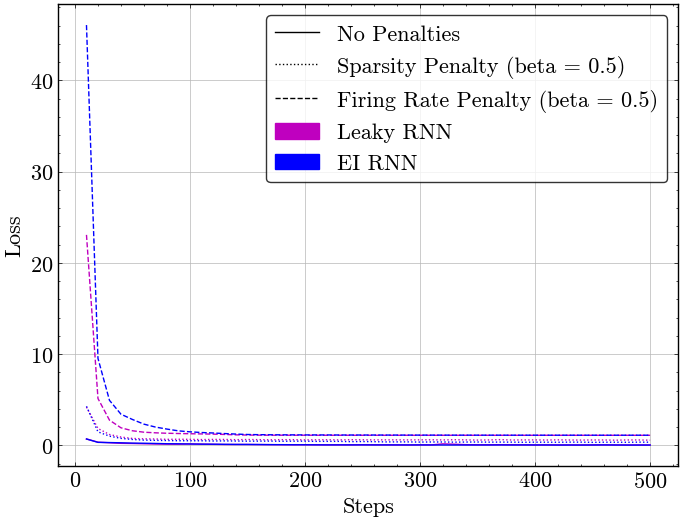

In [78]:
# create fig
plt.figure(figsize=(8, 6))

# define colours
leaky_rnn_color = 'm'  
ei_rnn_color = 'b'  

# define lines
line_styles = {
    'No Penalties': '-',  
    'Sparsity Penalty': ':',  
    'Firing Rate Penalty': '--',  
}


# leaky RNN (m1)
plt.plot(m1_np_s, m1_np_l, color=leaky_rnn_color, linestyle=line_styles['No Penalties'])
plt.plot(m1_sp_s, m1_sp_l, color=leaky_rnn_color, linestyle=line_styles['Sparsity Penalty'])
plt.plot(m1_lfr_s, m1_lfr_l, color=leaky_rnn_color, linestyle=line_styles['Firing Rate Penalty'])

# EI RNN (m2)
plt.plot(m2_np_s, m2_np_l, color=ei_rnn_color, linestyle=line_styles['No Penalties'])
plt.plot(m2_sp_s, m2_sp_l, color=ei_rnn_color, linestyle=line_styles['Sparsity Penalty'])
plt.plot(m2_lfr_s, m2_lfr_l, color=ei_rnn_color, linestyle=line_styles['Firing Rate Penalty'])

# custom legend
legend_elements = [
    mlines.Line2D([], [], color='k', linestyle=line_styles['No Penalties'], label='No Penalties'),
    mlines.Line2D([], [], color='k', linestyle=line_styles['Sparsity Penalty'], label='Sparsity Penalty (beta = 0.5)'),
    mlines.Line2D([], [], color='k', linestyle=line_styles['Firing Rate Penalty'], label='Firing Rate Penalty (beta = 0.5)'),
    mpatches.Patch(color=leaky_rnn_color, label='Leaky RNN'),
    mpatches.Patch(color=ei_rnn_color, label='EI RNN')
]

plt.xlabel('Steps')
plt.ylabel('Loss')

# add legend
plt.legend(handles=legend_elements)

# Show plot
plt.show()

Neural Activity

In [129]:
# from lab 4, adapted to work for LeakyRNN and EI RNN
def plot_network_connectivity(net, env, num_trial=500):
    """
    Function to plot network connectivity from a trained model.

    Args:
    - net (torch.nn.Module): The trained neural network model.
    - env (Environment): The environment used for training and testing.
    - num_trial (int): The number of trials to run for performance and activity recording.
    """
    # Reset the environment
    env.reset(no_step=True)
    env.timing.update({'fixation': ('constant', 500),
                       'stimulus': ('constant', 500)})
    
    # Initialize variables to track performance, activity, and trial information
    activity_dict = {}
    trial_infos = {}
    stim_activity = [[], []] 
    
    # Run trials
    for i in range(num_trial):
        env.new_trial()
        ob, gt = env.ob, env.gt
        inputs = torch.from_numpy(ob[:, np.newaxis, :]).type(torch.float)
        action_pred, rnn_activity = net(inputs)

        # Compute performance
        action_pred = action_pred.detach().numpy()
        choice = np.argmax(action_pred[-1, 0, :])
        correct = choice == gt[-1]

        # Log trial info
        trial_info = env.trial
        trial_info.update({'correct': correct, 'choice': choice})
        trial_infos[i] = trial_info

        # Log stimulus period activity
        rnn_activity = rnn_activity[:, 0, :].detach().numpy()
        activity_dict[i] = rnn_activity

        # Compute stimulus selectivity for all units
        rnn_activity = rnn_activity[env.start_ind['stimulus']: env.end_ind['stimulus']]
        stim_activity[env.trial['ground_truth']].append(rnn_activity)
    
    # Compute stimulus selectivity for sorting neurons
    mean_activity = []
    std_activity = []
    for ground_truth in [0, 1]:
        activity = np.concatenate(stim_activity[ground_truth], axis=0)
        mean_activity.append(np.mean(activity, axis=0))
        std_activity.append(np.std(activity, axis=0))

    # Compute d' (stimulus selectivity)
    selectivity = (mean_activity[0] - mean_activity[1])
    selectivity /= np.sqrt((std_activity[0]**2 + std_activity[1]**2 + 1e-7) / 2)

    if hasattr(net.rnn, 'e_size'):
        # EI RNN: Sort neurons by selectivity
        e_size = net.rnn.e_size
        ind_sort = np.concatenate((np.argsort(selectivity[:e_size]), 
                                   np.argsort(selectivity[e_size:]) + e_size))
    else:
        # LeakyRNN: Treat all neurons the same
        e_size = net.rnn.hidden_size  # Treat total hidden size as the number of neurons
        ind_sort = np.argsort(selectivity)

    # Accessing weights
    if hasattr(net.rnn.h2h, 'effective_weight'):
        # EI RNN: Use effective weight
        W = net.rnn.h2h.effective_weight().detach().numpy()  
    else:
        # LeakyRNN: Use regular weight
        W = net.rnn.h2h.weight.detach().numpy()  
    
    # Sort weights by selectivity
    W = W[:, ind_sort][ind_sort, :]
    wlim = np.max(np.abs(W))

    # plot network connectivity
    plt.figure(figsize=(8, 6))
    plt.imshow(W, cmap='bwr_r', vmin=-wlim, vmax=wlim)
    plt.colorbar(label='Weight Value')
    plt.xlabel('From neurons')
    plt.ylabel('To neurons')
    plt.show()



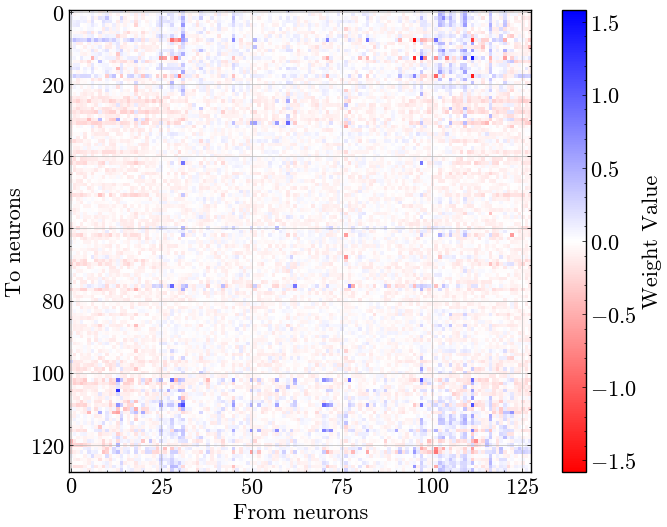

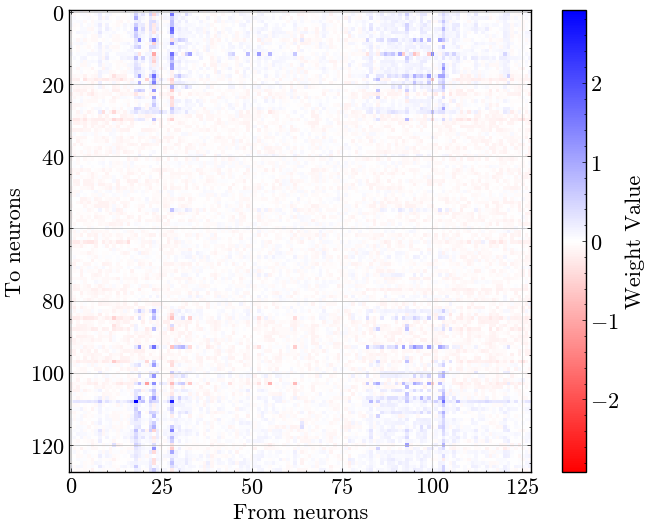

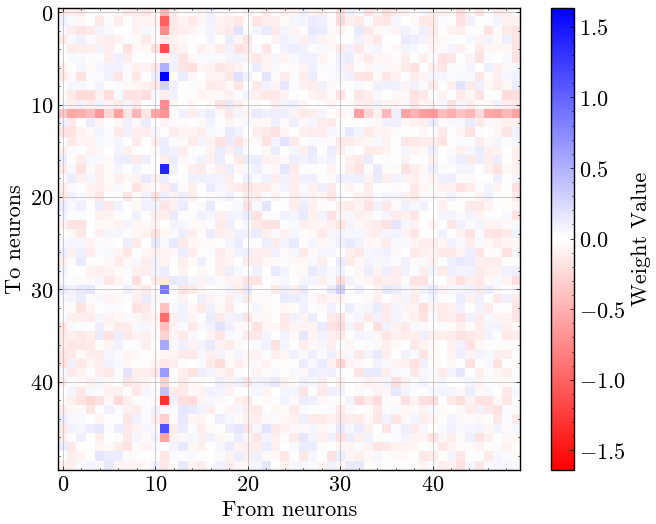

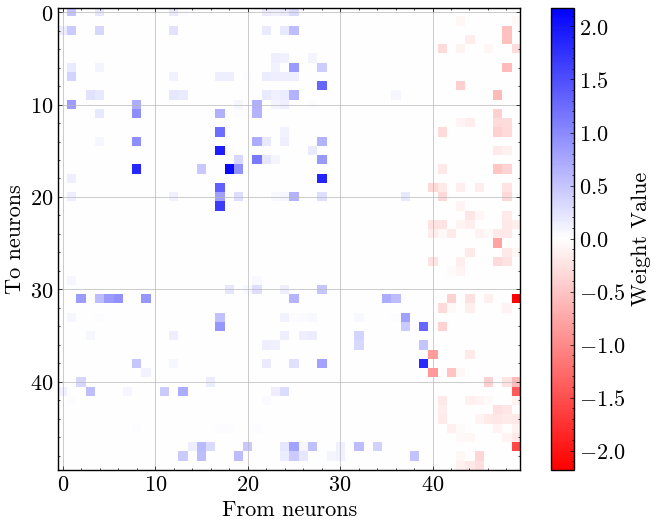

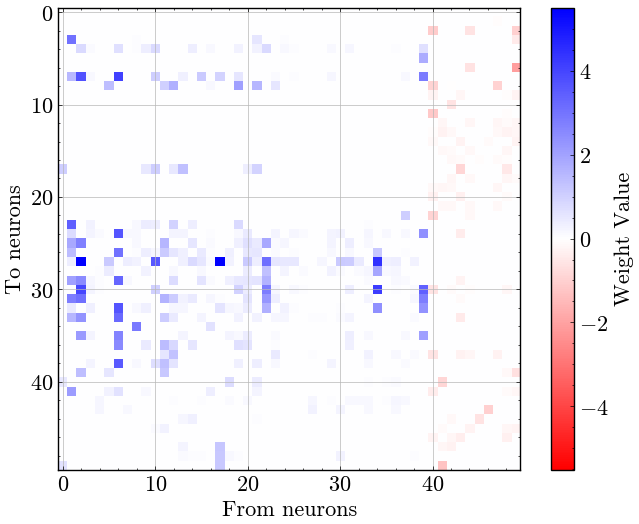

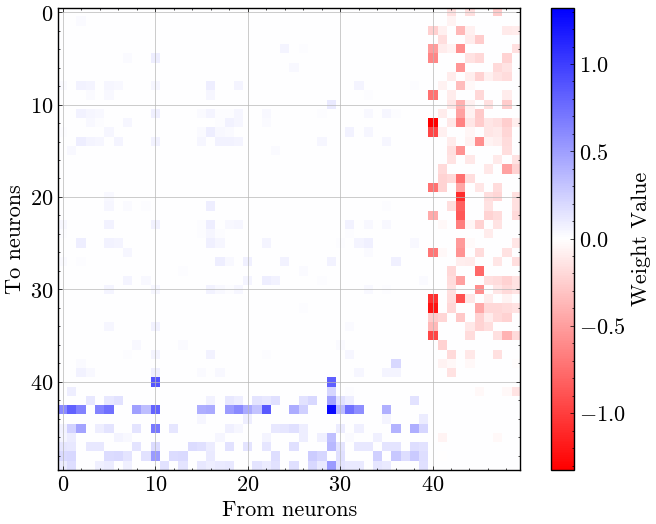

In [130]:
# plot for models and cost functions
# Leaky RNN
plot_network_connectivity(net_m1_np, env)

plot_network_connectivity(net_m1_sp, env)

plot_network_connectivity(net_m1_lfr, env)

# EI RNN
plot_network_connectivity(net_m2_np, env)

plot_network_connectivity(net_m2_sp, env)

plot_network_connectivity(net_m2_lfr, env)


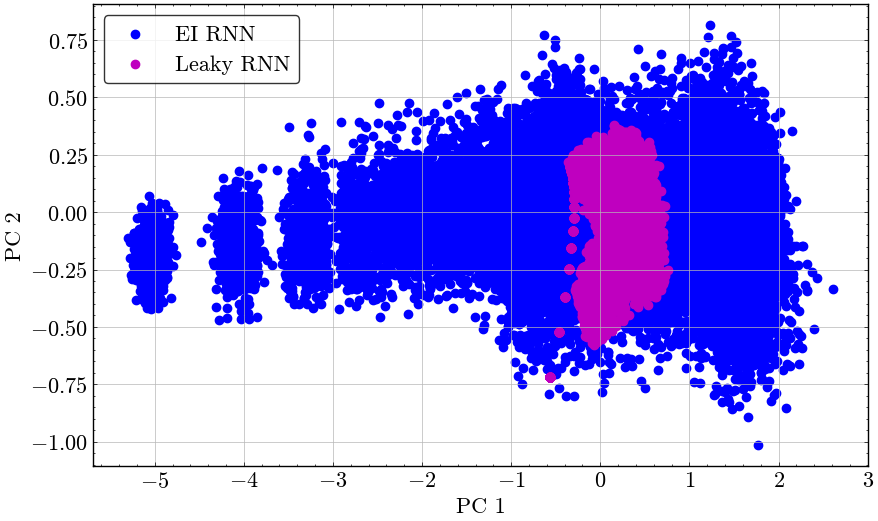

In [140]:
def analyze_hidden_unit_activity_PCA(net, env, num_trial=500):
    """
    Analyze the hidden unit activity of a trained RNN model over multiple trials using PCA.
    
    Args:
    - net (torch.nn.Module): The trained neural network model.
    - env (Environment): The environment used for training and testing.
    - num_trial (int): The number of trials to run for activity recording.
    - return_pca_data (bool): Whether to return PCA-transformed data.
    
    Returns:
    - reduced_activations (np.ndarray): PCA-reduced data (if return_pca_data=True).
    """
    # Reset the environment
    env.reset(no_step=True)
    env.timing.update({'fixation': ('constant', 500), 
                       'stimulus': ('constant', 500)})
    
    # Initialize a dictionary to store hidden unit activity for each trial
    activation_data = {}

    # Run trials and collect activations - similar to what we did in lab 4
    for i in range(num_trial):
        env.new_trial()
        ob, gt = env.ob, env.gt
        inputs = torch.from_numpy(ob[:, np.newaxis, :]).type(torch.float)
        
        # Get model output and hidden unit activity
        action_pred, rnn_activity = net(inputs)
        
        # Store the hidden unit activations (assuming rnn_activity has shape [time, batch_size, num_units]) 
        rnn_activity = rnn_activity[:, 0, :].detach().numpy()  # Collect activity for the first batch
        activation_data[i] = rnn_activity
    
    # Prepare data for PCA
    all_activations = np.concatenate(list(activation_data.values()), axis=0) 
    
    # Perform PCA
    pca = PCA(n_components=2) # 2D PCA
    reduced_activations = pca.fit_transform(all_activations) 
    

    return reduced_activations

# Call the function for each network and collect PCA results
pca_m1 = analyze_hidden_unit_activity_PCA(net_m1_lfr, env)
pca_m2 = analyze_hidden_unit_activity_PCA(net_m2_lfr, env)

# Plot all PCA results on the same graph
plt.figure(figsize=(10, 6))
plt.scatter(pca_m2[:, 0], pca_m2[:, 1], label='EI RNN', color='b')
plt.scatter(pca_m1[:, 0], pca_m1[:, 1], label='Leaky RNN', color='m')  


# Add plot title and labels
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.legend()
plt.show()
